<a href="https://colab.research.google.com/github/fi-co/play-with-python/blob/main/Modelling_a_cognitive_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
!pip install wikipedia-api

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("ag_news", split='train[:1%]')  # just a small slice
texts = [x['text'] for x in dataset]
text_data = ' '.join(texts)
# print(text_data[:1000])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

I have `text_data` a string containing the full corpus

## preprocessing

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Step-by-step preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text_data.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing
tokens = preprocess(text_data)

# Preview
print(tokens[:50])

In [ ]:
from collections import Counter

# Count frequencies
token_counts = Counter(tokens)

# Preview top 30 frequent tokens
top_tokens = token_counts.most_common(30)

print("Top 30 frequent tokens:")
for word, freq in top_tokens:
    print(f"{word}: {freq}")

Top 30 frequent tokens:
ap: 377
reuters: 307
monday: 209
new: 202
u: 170
said: 169
sunday: 120
company: 113
year: 109
oil: 101
first: 98
could: 92
team: 86
inc: 80
google: 80
one: 80
athens: 78
time: 77
world: 74
say: 73
president: 73
plan: 73
software: 72
price: 71
stock: 69
state: 64
week: 63
two: 63
may: 62
olympic: 61


In [ ]:
blacklist = ['ap','u', 'could']

# Filtered list of top 30 clean concepts
filtered_top_tokens = [(word, freq) for word, freq in top_tokens if word not in blacklist]

concept_list = [word for word, freq in filtered_top_tokens]

print("Filtered Top Tokens:")
for word, freq in filtered_top_tokens:
    print(f"{word}: {freq}")

Filtered Top Tokens:
reuters: 307
monday: 209
new: 202
said: 169
sunday: 120
company: 113
year: 109
oil: 101
first: 98
team: 86
inc: 80
google: 80
one: 80
athens: 78
time: 77
world: 74
say: 73
president: 73
plan: 73
software: 72
price: 71
stock: 69
state: 64
week: 63
two: 63
may: 62
olympic: 61


I have now `concept_list` a py list of clean, frequent semantic concepts

## Generate embeddings

In [ ]:
!pip install transformers
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
# Load BERT
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

def get_embedding(word):
    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    # Average all token embeddings (typically 1-2 subwords)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

concept_emb = {}

for word in concept_list:
  try:
    embedding = get_embedding(word)
    concept_emb[word] = embedding
  except Exception as e:
    print(f"Error processing {word}: {e}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

I have now a dict with concepts embeddings `concept_emb`

## Build the cognitive (semantic) network

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx

# Create empty graph
G = nx.Graph()

# Add nodes
for word in concept_emb:
    G.add_node(word)

# Add edges based on cosine similarity threshold
threshold = 0.75  # adjust to tune connectivity
concepts = list(concept_emb.keys())

for i in range(len(concepts)):
    for j in range(i + 1, len(concepts)):
        w1, w2 = concepts[i], concepts[j]
        vec1, vec2 = concept_emb[w1], concept_emb[w2]
        sim = cosine_similarity([vec1], [vec2])[0][0]
        if sim > threshold:
            G.add_edge(w1, w2, weight=sim)

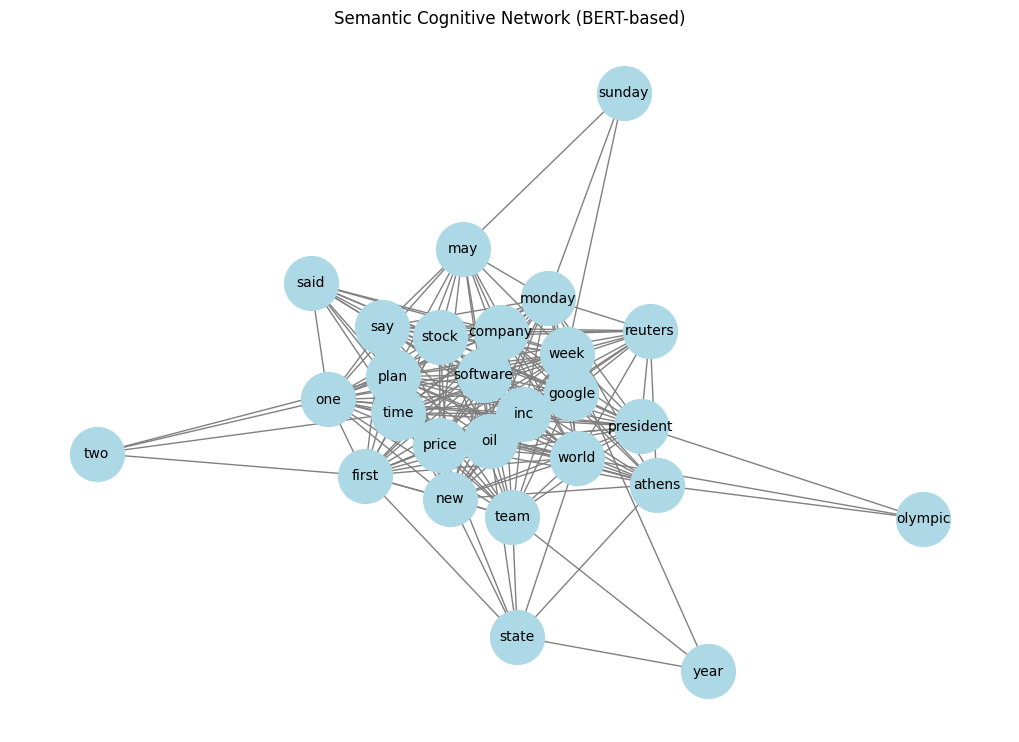

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500, font_size=10)
plt.title("Semantic Cognitive Network (BERT-based)")
plt.show()

## Network analyses

In [ ]:
import networkx as nx

# Degree centrality (how connected each concept is)
degree_centrality = nx.degree_centrality(G)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

print("Top 10 Concepts by Degree Centrality:")
for word, centrality in sorted_degree[:10]:
    print(f"{word}: {centrality:.3f}")

# Optional: Betweenness centrality (concepts connecting different parts of network)
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 Concepts by Betweenness Centrality:")
for word, centrality in sorted_betweenness[:10]:
    print(f"{word}: {centrality:.3f}")

Top 10 Concepts by Degree Centrality:
time: 0.846
world: 0.846
plan: 0.846
price: 0.846
company: 0.808
oil: 0.808
software: 0.808
monday: 0.769
inc: 0.769
google: 0.769

Top 10 Concepts by Betweenness Centrality:
week: 0.065
world: 0.046
monday: 0.033
team: 0.031
time: 0.027
plan: 0.027
president: 0.025
first: 0.023
price: 0.020
athens: 0.020


In [ ]:
# Eigenvector Centrality (Optional)
eigen_centrality = nx.eigenvector_centrality(G, max_iter=500)
sorted_eigen = sorted(eigen_centrality.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 Concepts by Eigenvector Centrality:")
for word, centrality in sorted_eigen[:10]:
    print(f"{word}: {centrality:.3f}")


Top 10 Concepts by Eigenvector Centrality:
price: 0.238
time: 0.236
plan: 0.236
company: 0.234
software: 0.234
world: 0.233
oil: 0.231
stock: 0.226
google: 0.226
inc: 0.223


In [ ]:
!pip install python-louvain


In [ ]:
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(G)

# Group nodes by community
from collections import defaultdict
community_groups = defaultdict(list)
for word, community_id in partition.items():
    community_groups[community_id].append(word)

print("\nSemantic Clusters (Communities):")
for community_id, words in community_groups.items():
    print(f"\nCluster {community_id+1}: {words}")

print("\nBasic Network Metrics:")
print(f"- Number of Nodes: {G.number_of_nodes()}")
print(f"- Number of Edges: {G.number_of_edges()}")
print(f"- Density: {nx.density(G):.3f}")
print(f"- Average Clustering Coefficient: {nx.average_clustering(G):.3f}")


Semantic Clusters (Communities):

Cluster 1: ['reuters', 'said', 'company', 'inc', 'google', 'athens', 'say', 'plan', 'software', 'price', 'stock']

Cluster 2: ['monday', 'sunday', 'week', 'may']

Cluster 3: ['new', 'year', 'oil', 'team', 'world', 'president', 'state', 'olympic']

Cluster 4: ['first', 'one', 'time', 'two']

Basic Network Metrics:
- Number of Nodes: 27
- Number of Edges: 219
- Density: 0.624
- Average Clustering Coefficient: 0.834


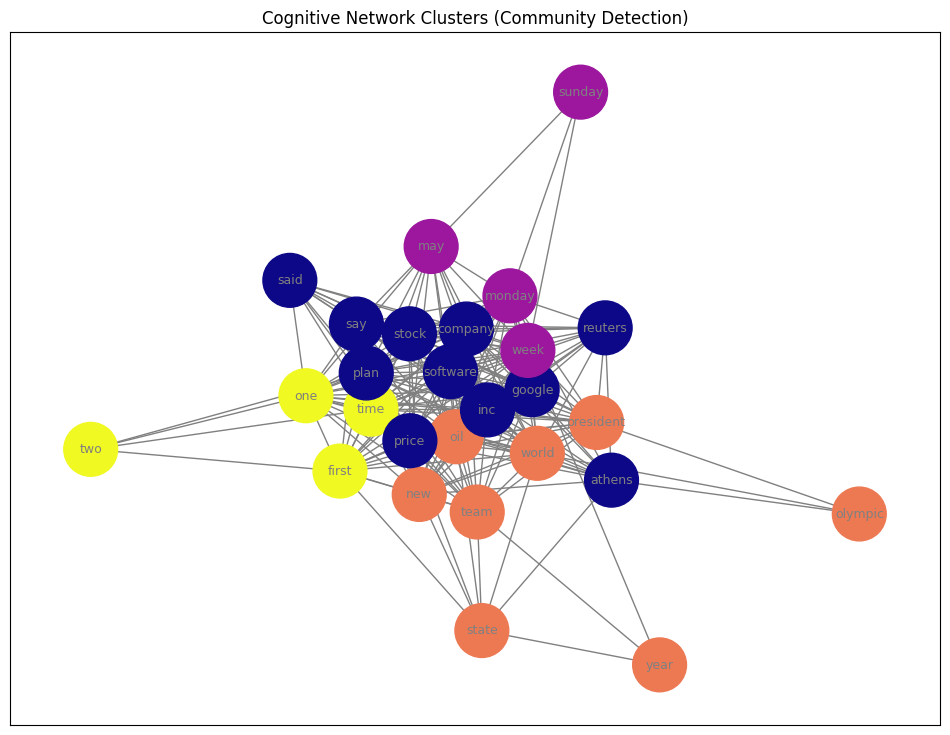

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, seed=42)

# Nodes colored by community
colors = [partition[node] for node in G.nodes()]
nx.draw_networkx(G, pos, node_color=colors, cmap='plasma', with_labels=True, edge_color='gray', node_size=1500, font_size=9, font_color="grey")
plt.title("Cognitive Network Clusters (Community Detection)")
plt.show()

In [ ]:
import numpy as np

def spreading_activation(G, prime, steps=2, decay=0.5):
  # Initialize activation dictionary
    activation = {node: 0.0 for node in G.nodes()}
    activation[prime] = 1.0  # Prime starts fully activated

    # Iterate spreading activation steps
    for step in range(steps):
        new_activation = activation.copy()
        for node in G.nodes():
            for neighbor in G.neighbors(node):
                # Activation spreads based on edge weight and decays over steps
                new_activation[neighbor] += activation[node] * G[node][neighbor]['weight'] * decay
        activation = new_activation

    # Normalize activations for easier interpretation
    max_activation = max(activation.values())
    if max_activation > 0:
        activation = {node: act / max_activation for node, act in activation.items()}

    return activation

In [ ]:
# Example with "market" as prime
prime_concept = "time"
activation_results = spreading_activation(G, prime=prime_concept, steps=3, decay=0.5)

# Sort activations by strength
sorted_activations = sorted(activation_results.items(), key=lambda x: x[1], reverse=True)

# Show top activated concepts
print(f"Semantic priming simulation starting from '{prime_concept}':")
for concept, activation in sorted_activations[:10]:
    print(f"{concept}: {activation:.3f}")

Semantic priming simulation starting from 'time':
plan: 1.000
time: 0.988
price: 0.987
company: 0.969
software: 0.958
world: 0.943
oil: 0.929
stock: 0.921
inc: 0.919
google: 0.916
